# Topic Modeling/NMF


### CREDITS

Notebook designed by Jack Bennetto. Small minor modifications by J.F. Omhover, Moses Marsh

## Objectives

 * Write down and explain NMF equation
 * Compare and contrast NMF, SVD/PCA
 * Implement Alternating-Least-Squares algorithm
 * Use NMF to find and interpret latent topics

## Agenda

 * Discussion of topic modeling
 * Problems with SVD for topic analysis
 * Introduce NMF
 * Review solving linear equations
 * Alternating Least Squares
 * NMF for topic analysis example
 * Pair exercise

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Topic Modeling

### 1.1. Motivation and connections

For most of this program we've talked about $X$ being a matrix of samples and features which are very different things. With SVD yesterday, NMF today, and recommender systems over the next few days, the rows and columns look a lot more like each other. When we figure out how they fit together, we don't just care about clustering the rows, but clustering the columns as well.  These 'topics' (a.k.a. 'concepts', 'latent features' or 'archetype') apply to both axis.

Examples:
 * Recommender systems mapping items to users
 * NLP mapping words to documents
 * Image processing mapping pixels to pictures

With SVD the relation to a topic is purely numeric, but with NMF the mapping we require all entries are non-negative, so we can see the rows (or columns!) as being part of a topic or not (if zero). That said, it's still a 'soft clustering', as rows (or columns) can be part of more than one topic.

Requiring entries to be non-negative provides more interpretable mappings and leads to a parts-based representation of the whole (https://github.com/gSchool/DSI_Lectures/blob/master/topicmodeling/moses_marsh/1999-Lee-Seung-Learning-Parts-of-Objects-by-NMF.pdf).

### 1.2. Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

In [2]:
movies = ['Matrix','Alien','StarWars','Casablanca','Titanic']
users = ['Alice','Bob','Cindy','Dan','Emily','Frank','Greg']
M = pd.DataFrame([[1, 2, 2, 0, 0],
                  [3, 5, 5, 0, 0],
                  [4, 4, 4, 0, 0],
                  [5, 5, 5, 0, 0],
                  [0, 2, 0, 4, 4],
                  [0, 0, 0, 5, 5],
                  [0, 1, 0, 2, 2]],
                 index=users, columns=movies)
display(M)

,Matrix,Alien,StarWars,Casablanca,Titanic
Alice,1,2,2,0,0
Bob,3,5,5,0,0
Cindy,4,4,4,0,0
Dan,5,5,5,0,0
Emily,0,2,0,4,4
Frank,0,0,0,5,5
Greg,0,1,0,2,2


We should able to group together these movies and find topics with math.

In [3]:
from numpy.linalg import svd

# Compute SVD
U, sigma, VT = svd(M)

U = pd.DataFrame(U, index=users)
VT = pd.DataFrame(VT, columns=movies)

display(U)
display(pd.DataFrame(np.diag(sigma)))
display(VT)

,0,1,2,3,4,5,6
Alice,-0.212143,0.023589,0.305276,-0.255204,5.083340e-01,-6.558738e-01,3.279369e-01
Bob,-0.548510,0.063954,0.532055,-0.461449,-2.541670e-01,3.279369e-01,-1.639685e-01
Cindy,-0.496897,0.067105,-0.313985,0.195839,6.665456e-01,3.659153e-01,-1.829576e-01
Dan,-0.621122,0.083882,-0.392481,0.244799,-4.824031e-01,-3.583196e-01,1.791598e-01
Emily,-0.124855,-0.596778,0.395328,0.521520,6.256198e-17,-2.000000e-01,-4.000000e-01
Frank,-0.044133,-0.733917,-0.419213,-0.532615,-1.998401e-16,5.172215e-17,-2.586108e-17
Greg,-0.062428,-0.298389,0.197664,0.260760,3.525412e-18,4.000000e-01,8.000000e-01


,0,1,2,3,4
0,13.83664,0.0000,0.000000,0.000000,0.000000e+00
1,0.00000,9.5214,0.000000,0.000000,0.000000e+00
2,0.00000,0.0000,1.687835,0.000000,0.000000e+00
3,0.00000,0.0000,0.000000,1.020568,0.000000e+00
4,0.00000,0.0000,0.000000,0.000000,1.570092e-16


,Matrix,Alien,StarWars,Casablanca,Titanic
0,-0.502352,-6.195268e-01,-5.969679e-01,-0.061066,-0.061066
1,0.094868,-4.591414e-02,1.107797e-01,-0.698792,-0.698792
2,-0.780233,6.166497e-01,3.109445e-02,-0.070756,-0.070756
3,0.360387,4.835511e-01,-7.939712e-01,-0.054357,-0.054357
4,-0.000000,-7.248355e-17,7.248355e-17,0.707107,-0.707107


In [4]:
# Keep top two concepts
k = 2

U = U.iloc[:,:k]
sigma = sigma[:k]
VT = VT.iloc[:k,:]

# Make pretty
U, sigma, VT = (np.around(x,2) for x in (U,sigma,VT))

display(U)
display(pd.DataFrame(np.diag(sigma)))
display(VT)

,0,1
Alice,-0.21,0.02
Bob,-0.55,0.06
Cindy,-0.50,0.07
Dan,-0.62,0.08
Emily,-0.12,-0.60
Frank,-0.04,-0.73
Greg,-0.06,-0.30


,0,1
0,13.84,0.00
1,0.00,9.52


,Matrix,Alien,StarWars,Casablanca,Titanic
0,-0.50,-0.62,-0.60,-0.06,-0.06
1,0.09,-0.05,0.11,-0.70,-0.70


**Discussion**
1. What do the concepts mean?
2. To which concept(s) does each user/document belong?

## 2. Non-negative Matrix Factorization (NMF)



Suppose we have a matrix $V \in \mathbb{R}^{m \times n}$. With NMF, we try to write it as the product of two smaller matrices, $W \in \mathbb{R}^{m \times r}$ and $H \in \mathbb{R}^{r \times n}$, 

$$ V = W H$$

or, to be more graphical,

$$\begin{bmatrix}
    v_{11}       & v_{12} & v_{13} & \dots & v_{1n} \\
    v_{21}       & v_{22} & v_{23} & \dots & v_{2n} \\
    v_{31}       & v_{32} & v_{33} & \dots & v_{3n} \\
    v_{41}       & v_{42} & v_{43} & \dots & v_{4n} \\
    \vdots       & \vdots & \vdots & \ddots& \vdots \\
    v_{m1}       & v_{m2} & v_{m3} & \dots & v_{mn}
\end{bmatrix}
=
\begin{bmatrix}
    w_{11}       & \dots & w_{1r} \\
    w_{21}       & \dots & w_{2r} \\
    w_{31}       & \dots & w_{3r} \\
    w_{41}       & \dots & w_{4r} \\
    \vdots       & \ddots& \vdots \\
    w_{m1}       & \dots & w_{mr}
\end{bmatrix}
\cdot
\begin{bmatrix}
    h_{11}       & h_{12} & h_{13} & \dots & h_{1n} \\
    \vdots       & \vdots & \vdots & \ddots& \vdots \\
    h_{r1}       & h_{r2} & h_{r3} & \dots & h_{rn}
\end{bmatrix}
$$

with the constraint that all $w_{ik} \ge 0$ and $h_{kj} \ge 0$.

In general, this isn't possible, but we'll try to do the best we can, minimizing the Frobenius norm of the residuals:

$$||V - WH||^2 = \sum_{ij} (V_{ij} - \sum_k W_{ik} H_{kj})^2$$

again with the constraint that the components are greater than zero.

Note that the number of topics $r$ is a hyperparameter; we can choose how many topics we want.

**Question** What would the value of $r$ have to do with the bias-variance tradeoff?

**Question** What would we lose compared to SVD?

### 2.1. Solving NMF

There are a couple approaches to solving NMF.

**Alternating Least Squares** involves solving first for one matrix while holding the other constant, that the other, back and forth until in converges.

**Stochastic Gradient Descent** minimizes the components of the matrices using the previously discussed algorithm.

### 2.2. Alternating Least Squares

First, some review.

#### 2.2.1. Exact solution for a system of linear equations
$$ Ax = b$$

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \end{array} \right] $$

There are two unknowns ($x_1$ and $x_2$) and two equations ($x_1 + 2x_2 = 7$ and $-3x_1 + 4x_2 = -9$) so (usually) there is one solution.

In [5]:
A = np.array([[1, 2], [-3, 4]])
b = np.array([7, -9])

print np.linalg.solve(A, b)

[ 4.6  1.2]


### 2.3. Least-squares solver

What if we have an overdetermined system of linear equations? E.g.

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \\ 1 & -4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \\ 17 \end{array} \right] $$

An exact solution is not guaranteed, so we must do something else. Least Squares dictates that we find the $x$ that minimizes the residual sum of squares (RSS).

(Note: This is the solver we use when doing Linear Regression!)

In [6]:
A = np.array([[1, 2], [-3, 4], [1, -4]])
b = np.array([7, -9, 17])

print np.linalg.lstsq(A, b)[0]
print "Residual sum of squares (error): {}".format(np.linalg.lstsq(A, b)[1])

[ 2.88 -1.38]
Residual sum of squares (error): [ 147.92]


In [10]:
np.linalg.lstsq(A,b)

(array([ 2.88, -1.38]), array([ 147.92]), 2, array([ 6.50140941,  2.17524151]))

### 2.4. Alternating Least Squares

**Question** Given a matrices $A$ and $B$, least squares and non-negative least squares find the solution $X$ that minimizes the error (RSS) in $A \cdot X = B$. So can you guess what alternating least squares is, and how may we apply it to NMF?

First, let's create a matrix $V$ with some random values.

In [8]:
V = np.random.rand(10,15)

Now we want to find matrices $W$ and $H$ such that $W \cdot H = V$ (or as close as we can get). In general we need to start at some random point, so we'll initialize one of our matrices with some random values.

In [9]:
# Initialize a random matrix W
W = np.random.rand(10,5)

Now we can solve the for $H$ in the above equation.

**Question** Why don't we initialize the matrix with all zeros?

In [10]:
# Solve for H using a least squares solver
H = np.linalg.lstsq(W, V)[0]

# Clip H so there are no negative values
H[H < 0] = 0

# Print the current error. Why did the error go up?
print np.linalg.norm(V - np.dot(W,H))

3.25804713036


In [11]:
# Solve for W using H
W = np.linalg.lstsq(H, V)[0]

LinAlgError: Incompatible dimensions

Dang...that didn't work... Let's do some math to figure out why and what we could have done

**Question** np.linalg.lstsq(W, V) solves $W \cdot H = V$. To solve for W we need to solve $H \cdot W = V$ which is invalid due to the dimensions of H and W. What can we do to our matrices to make this fix this problem?

In [12]:
print W.shape
print H.shape
print V.shape

(10, 5)
(5, 15)
(10, 15)


In [13]:
W = np.linalg.lstsq(H.T, V.T)[0].T

In [14]:
print W.shape

(10, 5)


**Exercise** Using the answer provided, go ahead and solve for W and print out the new error

In [15]:
# Clip W so there are no negative values
W[W < 0] = 0

# Print the current error. Why did the error go up?
print np.linalg.norm(V - np.dot(W,H))

2.13896212957


With ALS, we continue this, H in terms of W and W in terms of H until
we are "satisfied" with your result (low enough error) or reach some maximum number of iterations.

### 2.5 Gradient descent & multiplicative update rules

See pp. 35-37 of Cary's notes
https://github.com/gSchool/DSI_Lectures/blob/master/topicmodeling/cary_goltermann/nmf.pdf

For more information on NMF solvers, check out: http://users.wfu.edu/plemmons/papers/BBLPP-rev.pdf

## 3. NMF for topic analysis

### 3.1. Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

In [16]:
display(M)

,Matrix,Alien,StarWars,Casablanca,Titanic
Alice,1,2,2,0,0
Bob,3,5,5,0,0
Cindy,4,4,4,0,0
Dan,5,5,5,0,0
Emily,0,2,0,4,4
Frank,0,0,0,5,5
Greg,0,1,0,2,2


And again, we'll try to find the topics.

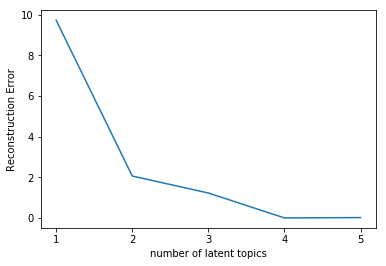

In [17]:
# Compute NMF
from sklearn.decomposition import NMF

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('number of latent topics')
plt.ylabel('Reconstruction Error')

**Question** What might be the optimal r (number of topics) value and why?

In [18]:
# Fit using 2 hidden concepts
nmf = NMF(n_components=2)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_
print 'RSS = %.2f' % nmf.reconstruction_err_

RSS = 2.06


In [19]:
# Make interpretable
W, H = (np.around(x,2) for x in (W,H))
W = pd.DataFrame(W,index=users)
H = pd.DataFrame(H,columns=movies)

display(W) 
display(H)

,0,1
Alice,0.79,0.01
Bob,2.04,0.01
Cindy,1.85,0.00
Dan,2.31,0.00
Emily,0.21,1.88
Frank,0.00,2.28
Greg,0.11,0.94


,Matrix,Alien,StarWars,Casablanca,Titanic
0,1.9,2.28,2.26,0.00,0.00
1,0.0,0.37,0.00,2.17,2.17


**Discussion**
1. What do the concepts (clusters) mean?
2. To which concept(s) does each user/document belong?

In [20]:
# Verify reconstruction
display(np.around(W.dot(H),2))
display(pd.DataFrame(M, index=users, columns=movies))

,Matrix,Alien,StarWars,Casablanca,Titanic
Alice,1.50,1.80,1.79,0.02,0.02
Bob,3.88,4.65,4.61,0.02,0.02
Cindy,3.52,4.22,4.18,0.00,0.00
Dan,4.39,5.27,5.22,0.00,0.00
Emily,0.40,1.17,0.47,4.08,4.08
Frank,0.00,0.84,0.00,4.95,4.95
Greg,0.21,0.60,0.25,2.04,2.04


,Matrix,Alien,StarWars,Casablanca,Titanic
Alice,1,2,2,0,0
Bob,3,5,5,0,0
Cindy,4,4,4,0,0
Dan,5,5,5,0,0
Emily,0,2,0,4,4
Frank,0,0,0,5,5
Greg,0,1,0,2,2


#### What is concept 0?

In [21]:
# Top movies in genre 0
H.iloc[0].sort_values(ascending=False)

Alien         2.28
StarWars      2.26
Matrix        1.90
Titanic       0.00
Casablanca    0.00
Name: 0, dtype: float64

#### Which users align with concept 0?

In [22]:
# Top users for genre 1
W.iloc[:,0].sort_values(ascending=False)

Dan      2.31
Bob      2.04
Cindy    1.85
Alice    0.79
Emily    0.21
Greg     0.11
Frank    0.00
Name: 0, dtype: float64

#### What concepts does Emily align with?

In [23]:
W.loc['Emily']

0    0.21
1    1.88
Name: Emily, dtype: float64

#### What are all the movies in each concept?

In [24]:
# Number of movies in each concept
thresh = .2  # movie is included if at least 20% of max weight

for g in range(2):
    all_movies = H.iloc[g,:]
    included = H.columns[all_movies >= (thresh * all_movies.max())]
    print "Concept %i contains: %s" % (g, ', '.join(included))

Concept 0 contains: Matrix, Alien, StarWars
Concept 1 contains: Casablanca, Titanic


#### Which users are associated with each concept?

In [25]:
# Users in each concept
thresh = .2  # user is included if at least 20% of max weight

for g in range(2):
    all_users = W.iloc[:,g]
    included = W.index[all_users >= (thresh * all_users.max())]
    print "Concept %i contains: %s" % (g, ', '.join(included))

Concept 0 contains: Alice, Bob, Cindy, Dan
Concept 1 contains: Emily, Frank, Greg


## 4. Additional notes

We can use **regularization** with NMF, adding a terms cost for large values in $W$ and $H$, with either an L1 or L2 penelty.

Some implementations (not sklearn) allow ignoring **missing values** in the original matrix. In a recommender these would correspond to unrated items.